<a href="https://colab.research.google.com/github/manavidubey/Attentio/blob/main/emotion_detection_comp_vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#fetching the dataset

import opendatasets as od

od.download(
	"https://www.kaggle.com/datasets/msambare/fer2013?resource=download")

Skipping, found downloaded files in "./fer2013" (use force=True to force download)


In [ ]:
#importing libraries

import os
import shutil
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get Number of Images for each Emotion and Splitting

train_path = "/content/fer2013/train"
test_path = "/content/fer2013/test"
emotions = os.listdir(train_path)

len_train = {}
len_public_test = {}
len_private_test = {}

for emotion in emotions:
    file_train = os.listdir(os.path.join(train_path, emotion))
    len_train[emotion] = len(file_train)
    
    file_test = os.listdir(os.path.join(test_path, emotion))
    file_public_test = [f for f in file_test if "Public" in f]
    file_private_test = [f for f in file_test if "Private" in f]
    len_public_test[emotion] = len(file_public_test)
    len_private_test[emotion] = len(file_private_test)

print("Train: ", len_train)
print("Public Test: ", len_public_test)
print("Private Test: ", len_private_test)

total_train = sum(len_train.values())
total_public_test = sum(len_public_test.values())
total_private_test = sum(len_private_test.values())

print("Total Train: ", total_train)
print("Total Public Test: ", total_public_test)
print("Total Private Test: ", total_private_test)

Train:  {'neutral': 4965, 'surprise': 3171, 'angry': 3995, 'disgust': 436, 'sad': 4830, 'happy': 7215, 'fear': 4097}
Public Test:  {'neutral': 607, 'surprise': 415, 'angry': 467, 'disgust': 56, 'sad': 653, 'happy': 895, 'fear': 496}
Private Test:  {'neutral': 626, 'surprise': 416, 'angry': 491, 'disgust': 55, 'sad': 594, 'happy': 879, 'fear': 528}
Total Train:  28709
Total Public Test:  3589
Total Private Test:  3589


In [ ]:
# Create a new subdirectory called PublicTest and move the public test images into it
if(os.path.exists("public_test")==False):
    os.mkdir("public_test")
for emotion in emotions:
    emotion_dir = "public_test/" + emotion
    if(os.path.exists(emotion_dir)==False):
        os.mkdir(emotion_dir)
    
    first_emotion_dir = os.path.join(test_path, emotion)
    file_test = os.listdir(first_emotion_dir)
    file_public_test = [f for f in file_test if "Public" in f]
    
    for i in range(len(file_public_test)):
        old_path = os.path.join(first_emotion_dir, file_public_test[i])
        new_path = os.path.join(emotion_dir, file_public_test[i])
        shutil.copyfile(old_path, new_path)

# Create a new subdirectory called PrivateTest and move the private test images into it
if(os.path.exists("private_test")==False):
    os.mkdir("private_test")
for emotion in emotions:
    emotion_dir = "private_test/" + emotion
    if(os.path.exists(emotion_dir)==False):
        os.mkdir(emotion_dir)
        
    first_emotion_dir = os.path.join(test_path, emotion)
    file_test = os.listdir(first_emotion_dir)
    file_private_test = [f for f in file_test if "Private" in f]
    
    for i in range(len(file_private_test)):
        old_path = os.path.join(first_emotion_dir, file_private_test[i])
        new_path = os.path.join(emotion_dir, file_private_test[i])
        shutil.copyfile(old_path, new_path)

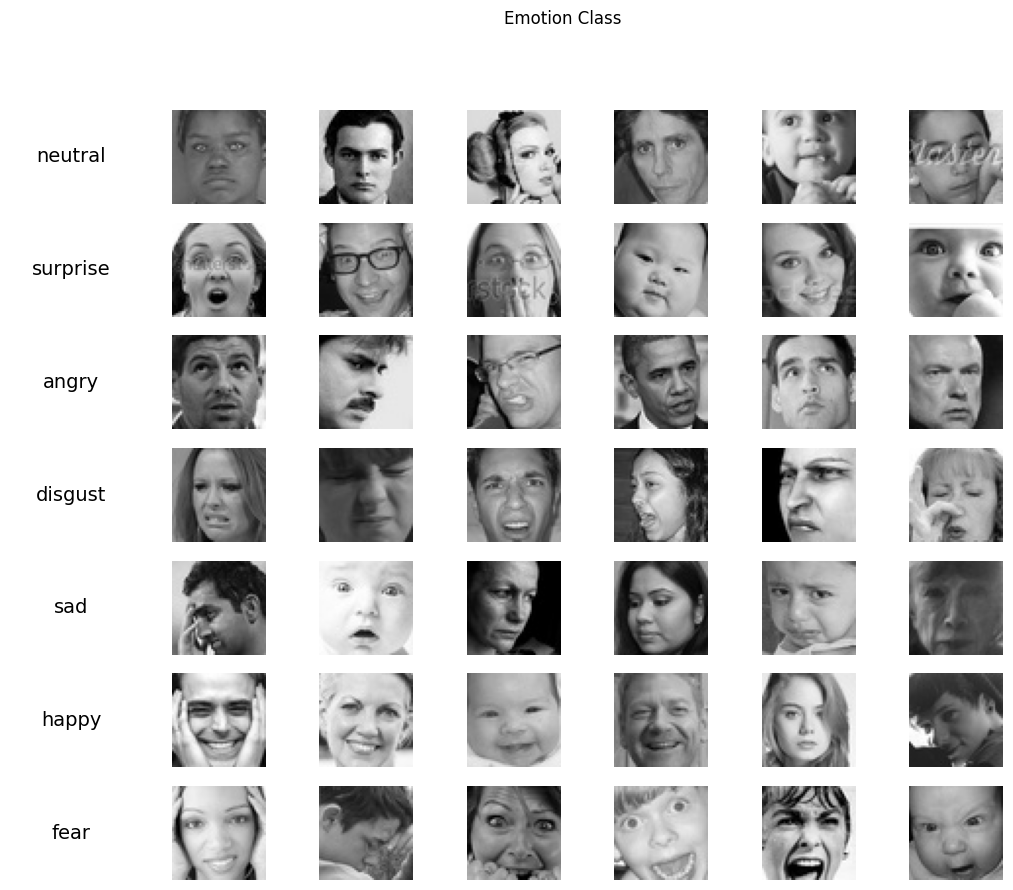

In [ ]:
# Create Subplots
fig, axs = plt.subplots(7, 7, figsize=(13, 10))

# Plot the Data
for i, emotion in enumerate(emotions):
    axs[i, 0].text(0.5, 0.5, emotion, ha='center', va='center', fontsize=14)
    axs[i, 0].axis('off')
    
    emotion_path = os.path.join(train_path, emotion)
    list_files = os.listdir(emotion_path)
    
    for j in range(6):
        idx = i*6+j
        if(idx < len(axs.flat)):
            image = load_img(os.path.join(emotion_path, list_files[j]))
            axs[i, j+1].imshow(image)
            axs[i, j+1].axis("off")

# Title
plt.suptitle("Emotion Class", x=0.55)

# Show
plt.show()

In [ ]:
#os.mkdir("/content/fer2013/test/nervousness")

In [ ]:
#os.mkdir("/content/fer2013/train/nervousness")

In [ ]:
# Data Augmentation
def data_augmentation():
    # Training Dataset
    TRAINING_DIR = "/content/fer2013/train"
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode="categorical",
        shuffle=True,
        subset="training"
    )

    # Validation Dataset
    validation_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode="categorical",
        shuffle=False,
        subset="validation"
    )

    # Public Testing Dataset
    PUBLIC_TESTING_DIR = "/content/public_test"
    public_test_datagen = ImageDataGenerator(rescale=1./255.)
    public_test_generator = public_test_datagen.flow_from_directory(
        PUBLIC_TESTING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=1,
        class_mode="categorical",
        shuffle=False
    )
    
    # Private Testing Dataset
    PRIVATE_TESTING_DIR = "/content/private_test"
    private_test_datagen = ImageDataGenerator(rescale=1./255.)
    private_test_generator = private_test_datagen.flow_from_directory(
        PRIVATE_TESTING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=1,
        class_mode="categorical",
        shuffle=False
    )
    
    return train_generator, validation_generator, public_test_generator, private_test_generator

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
class CFG:
    batch_size = 64
    img_height = 224
    img_width = 224
    epoch = 25

In [ ]:
# Create data augmentation
seed_everything(2023)
train_generator, validation_generator, public_test_generator, private_test_generator = data_augmentation()

# Load the MobileNet model without the top layer
base_model = MobileNet(
    input_shape=(CFG.img_height, CFG.img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Add a GlobalAveragePooling2D layer and a Dense layer with softmax activation for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine the base model with the new layers to create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-5), metrics=['accuracy'])

model.summary()

Found 22968 images belonging to 8 classes.
Found 5741 images belonging to 8 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv

In [ ]:
# Create Callback
model_checkpoint = ModelCheckpoint(
    "MobileNetV1.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [model_checkpoint]

In [ ]:
# Train the model on the training data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=callbacks,
)

Epoch 1/25
358/358 [==============================] - ETA: 0s - loss: 2.4962 - accuracy: 0.1861
Epoch 1: val_loss improved from inf to 1.86894, saving model to MobileNetV1.h5
358/358 [==============================] - 1572s 4s/step - loss: 2.4962 - accuracy: 0.1861 - val_loss: 1.8689 - val_accuracy: 0.2381
Epoch 2/25
358/358 [==============================] - ETA: 0s - loss: 2.2309 - accuracy: 0.2206
Epoch 2: val_loss improved from 1.86894 to 1.76001, saving model to MobileNetV1.h5
358/358 [==============================] - 1726s 5s/step - loss: 2.2309 - accuracy: 0.2206 - val_loss: 1.7600 - val_accuracy: 0.2927
Epoch 3/25
159/358 [============>.................] - ETA: 12:21 - loss: 2.0970 - accuracy: 0.2448